# POUR CÉLINA

Coucou CC, il nous ont donné un file .parquet (juste un autre format de stockage binaire, un peux comme pickle) que normalement j'ai mis dans le dossier Data. Il devrait contenir plusieures informations sur chaque speaker. Tu peux le load comme ça, mais il me semble qu'il faut installer pyarrow (  conda install -c conda-forge pyarrow  ).

Malheureusement il parait qu'ils aient utilisé le QID de Wikidata pour encoder la profession, religion et tout le reste. Probablement une des première choses à faire est de trouver un moyen de mapper les QIDS à des string, que je sais faire en faisant des queries à wikidata mais je me demande s'il n'y a pas un moyen plus simple. Au pire on le fait (que une fois de toute façon).

Il faudrait aussi s'assurer que dans le parquet qu'ils nous donnent il n'y ait pas que peu d'occupations au bol, mais un grand nombre comme celui qu'on voit sur wikidata, car autrement on a le même problème que quand je faisais les queries (que j'ai découvert comment resudre) qui est que pour des gens avec beaucoup de professions on en avait seulement 3 au bol.

Oubliepas que je t'ai dit qu'il y a un problème avec l'antivirus et la lecture de .json. Je ne sais pas pourquoi, mais à chaque fois que tu veux commencer à lire un json tu dois mettre en standby l'anti-virus pendant une minute. C'est assez chiant, mais je n'ai pas trouvé d'autre solution (sinon, le programme ne plante pas, il s'arrete juste et ne dit rien et attend jusqu'à que tu desactives).

Pour le moment c'est tout je crois.

## Importing libraries/modules

In [1]:
import utils
import numpy as np
import pandas as pd
import bz2
import json
import os
import time
import re

In [2]:
DATA_DIR = 'Data'
CACHE_DIR = 'Cache'
CACHE_FILE_PATH = os.path.join(CACHE_DIR, 'processed_data.json.bz2')

## Useful functions

In [3]:
@utils.cache_to_file_pickle("function-groupby_speaker", cache_dir = CACHE_DIR)
def groupby_speaker(input_file_path):
    """
    """
    speakers_dict = {}
    
    with bz2.open(input_file_path, 'rb') as input_file:
        start = time.time()
        
        for i, line in enumerate(input_file):
            line = json.loads(line)
            
            if not line['qids']:
                continue
            
            qids = tuple(line['qids']) if len(line['qids']) > 1 else line['qids'][0]
            
            # if multiple qids given for one quote, take the first one for now
            if qids in speakers_dict:
                speakers_dict[qids]['quote_count'] += 1
                speakers_dict[qids]['speaker']     |= set([line['speaker']])
                # speakers_dict[qids]['num_occurrences'].append(line['numOccurrences'])
                
                speakers_dict[qids]['num_occurrences'].append(len(line['domains']))
                
            else:
                speakers_dict[qids] = {'quote_count': 1, \
                                       'speaker': set([line['speaker']]),
                                       'num_occurrences': [len(line['domains'])]}
                                       # 'num_occurrences': [line['numOccurrences']]}
                
                
            if not i % 1000000:
                print("Read", i, "lines from", input_file_path, 'in', (time.time() - start) / 60, "minutes")
                
    return speakers_dict

## Choices to make

- Cas quand plusieurs qids par quote, lequel on prend ? (je sais pas s'il y a moyen de savoir laquelle est la plus populaire, peut-être celle qui a le plus de liens externes) 88% des fois c'est OK -> on les drop ?

- Il faut link les QIDs avec les strings correspondant aux informations

- Problème avec les dates of birth: quand mois/jour pas connu set à 0 -> datetime pas content, on garde que l'année peut-être suffisant ?
- Pour le gender quand pas connu je jette les données ?
- Idem pour les autres colonnes ? 

## Questions to answer

- How the age, occupation, genre,... influences in the virality of the speaker ?

## Load datasets

- Data from quote dataset

In [4]:
# Load data from quotes
data_quotes = groupby_speaker(input_file_path = CACHE_FILE_PATH)

# Convert them into pandas dataframe
data_quotes = pd.DataFrame(data_quotes).T

# Display 5 rows
data_quotes.head(5)

,quote_count,speaker,num_occurrences
Q270316,4449,"{Jeanne Shaheen, JEANNE SHAHEEN}","[2, 2, 1, 2, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 2, ..."
Q1253,13244,"{Ban Ki-Moon, BAN KI-MOON, Ban Ki moon, Ban ki...","[2, 1, 99, 1, 2, 1, 2, 91, 7, 1, 3, 2, 12, 1, ..."
Q468374,1076,{Sri Sri Ravi Shankar},"[1, 5, 1, 1, 1, 1, 1, 6, 1, 1, 1, 4, 1, 1, 9, ..."
Q19874690,212,{Jamal Rifi},"[1, 1, 1, 8, 2, 1, 1, 9, 1, 1, 2, 1, 2, 3, 1, ..."
Q18601741,14,{Richard Burmeister},"[1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


- Data from wikidata of speakers

In [6]:
def get_info_speakers(list_tuples_qids):
    # Load data of wikidata from parquet
    speaker_data = pd.read_parquet('Data/speaker_attributes.parquet')

    all_qids = set()
    for qids in list_tuples_qids:
        all_qids |= set(qids)
    
    speaker_data = speaker_data[speaker_data['id'].isin(all_qids)]
    
    return speaker_data

    
speaker_data = get_info_speakers(data_quotes.index)

# Display 3 rows
speaker_data.head(3)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
8,"[Neil Percival Young, Shakey, Godfather of Gru...",[+1945-11-12T00:00:00Z],"[Q16, Q30]",[Q6581097],1395459626,None,None,"[Q177220, Q488205, Q2526255, Q639669, Q1881462...",None,None,Q633,Neil Young,None,item,None
38,None,[+1981-08-30T00:00:00Z],[Q36],[Q6581097],1393526571,None,None,"[Q18534714, Q11513337]",None,None,Q1755,Tomasz Majewski,None,item,None


## Data Cleaning

#### 1) Data from quote

- Manage when multiple QID for one person

In [1]:
tot = 0
for ids in data_quotes_df.index:
    if ids is None:
        continue
        
    if isinstance(ids, str):
        ids = [ids]
    
    if len(ids) == 1:
        tot += 1

NameError: name 'data_quotes_df' is not defined

In [10]:
print("Percentage of data with exactly one QID: ", 100*tot/data_quotes_df.index.shape[0], "%")

Percentage of data with exactly one QID:  88.07453258366075 %


#### 2) Data from wikidata

- Check we have no none qid for the speakers in the parquet

In [11]:
speaker_data.id.isna().sum()

0

- Check dates of birth

In [21]:
pd.to_datetime(speaker_data.head(1)['date_of_birth'][0][0], format='+%Y-%m-%dT%H:%M:%S%z', errors='ignore')

Timestamp('1732-02-22 00:00:00+0000', tz='UTC')

In [86]:
speaker_data.head(1)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]


In [93]:
speaker_data.loc[speaker_data['date_of_birth'].isin(['+1969-00-00T00:00:00Z'])].head(1)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
9,None,[+1969-00-00T00:00:00Z],[Q183],[Q6581097],1340253739,None,None,"[Q33231, Q41546637]",None,None,Q640,Harald Krichel,None,item,None


In [105]:
speaker_data['gender'].isna().unique()

array([False,  True])

In [21]:
from collections import Counter

genders = Counter()
for qid, data in zip(speaker_data['id'], speaker_data['gender']):
    if data is not None and len(data) != 1:
        genders.update(data)

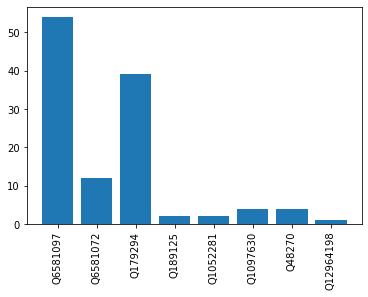

In [36]:
import matplotlib.pyplot as plt
plt.bar(genders.keys(), genders.values())
plt.xticks(rotation = 90);

In [56]:
qids = set()
for element in speaker_data[['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']].values.ravel():
    if element is not None:
        qids |= set(element)

In [86]:
utils.get_labels_of_wikidata_ids(qids)

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [35]:
speaker_data.loc[speaker_data["id"] == 'Q15735939']

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
7078648,[Christopher Douglas Matthews],[+1989-10-06T00:00:00Z],[Q30],[Q6581097],1317867389,[Q49085],None,"[Q19204627, Q19841381]",None,None,Q15735939,Chris Matthews,None,item,None


In [15]:
import requests

In [16]:
url = 'https://query.wikidata.org/sparql'
query = '''
SELECT ?item ?itemLabel ?linkcount 
WHERE {
    ?item wdt:P31/wdt:P279* wd:Q35666 .
    ?item wikibase:sitelinks ?linkcount .
    FILTER (?linkcount >= 1) .
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" . }
}

GROUP BY ?item ?itemLabel ?linkcount
ORDER BY DESC(?linkcount)
'''
r = requests.get(url, params = {'format': 'json', 'query': query})
data = r.json()

In [17]:
data

{'head': {'vars': ['item', 'itemLabel', 'linkcount']},
 'results': {'bindings': [{'item': {'type': 'uri',
     'value': 'http://www.wikidata.org/entity/Q39651'},
    'itemLabel': {'xml:lang': 'en',
     'type': 'literal',
     'value': 'Eyjafjallajökull'},
    'linkcount': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
     'type': 'literal',
     'value': '74'}},
   {'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q179734'},
    'itemLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Vatnajökull'},
    'linkcount': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
     'type': 'literal',
     'value': '61'}},
   {'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q200255'},
    'itemLabel': {'xml:lang': 'en',
     'type': 'literal',
     'value': 'Ross Ice Shelf'},
    'linkcount': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
     'type': 'literal',
     'value': '53'}},
   {'item': {'type': 'uri', 'value': 'http://www.w